 # **GPT Model from Scratch**
<img src="https://cdn.prod.website-files.com/649d5f7142f0800f8b55fbaa/64b57a26c8883a951510224e_641351aeefc0453800d820ec_co.gif" width="600px" style="border-radius: 15px;" />

---

**This notebook demonstrates how to create a tiny GPT model from scratch and train it on the classic Don Quijote text. This simplified GPT can learn character-level language modeling and generate new text that resembles the style of the novel.**

---

## **Table of Contents**
1. [Introduction](#introduction)
2. [Data Preparation](#data-preparation)
3. [Model Architecture](#model-architecture)
    - [The `BigramLanguageModel` Class](#the-bigramlanguagemodel-class)
    - [Transformer Building Blocks](#transformer-building-blocks)
        1. [Head](#1-head-self-attention-head)
        2. [MultiHeadAttention](#2-multiheadattention)
        3. [FeedForward](#3-feedforward)
        4. [Block](#4-block)
4. [Training the Model](#training-the-model)
5. [Sampling (Text Generation)](#sampling-text-generation)
6. [Visualizing Attention](#visualizing-attention)
---

## 1. **Introduction**

### What is GPT?

GPT (Generative Pre-trained Transformer) models are transformer-based language models that excel at generating coherent text by predicting the next token (in this case, the next character) given a sequence of previous tokens. GPT leverages:

- **Self-Attention**: Each token attends to every other token in the sequence to build powerful context-dependent representations.
- **Feedforward Layers**: Project intermediate representations into higher dimensions, apply a nonlinearity, and bring them back down, enabling complex transformations.
- **Layer Normalization**: Stabilizes and accelerates training by normalizing activations.
- **Positional Embeddings**: Since transformers have no inherent sense of order, we inject position information to preserve sequence ordering.

In this notebook, we use a **tiny** version of GPT—both in terms of fewer parameters and a simpler approach (e.g., single token-level tasks, character-based modeling, no advanced optimizations). Nonetheless, the code structure demonstrates the core Transformer *decoder* architecture.

---

## 2. **Data Preparation**

We will use the text of *Don Quijote* from [Project Gutenberg](https://www.gutenberg.org/ebooks/2000). We do a character-level approach, meaning each character in the text is a token.

In [1]:
# Download the book
!wget https://www.gutenberg.org/cache/epub/2000/pg2000.txt

# Read the text
with open('pg2000.txt', 'r') as f:
    text = f.read()

# Examine basic stats
vocab = sorted(list(set(text)))
vocab_size = len(vocab)
print(f'Number of characters in text: {len(text)}')
print(f'Unique characters (vocab size): {vocab_size}')

# Create mappings from characters to IDs and back
stoi = { ch:i for i, ch in enumerate(vocab) }
itos = { i:ch for i, ch in enumerate(vocab) }

# Helper functions
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Quick sanity check
sample_str = "En un lugar de la Mancha"
print("Encoded sample:\n", encode(sample_str))
print("Decoded sample:\n", decode(encode(sample_str)))

# Convert the entire text to a tensor of token IDs
import torch

data = torch.tensor(encode(text), dtype=torch.long)
print("Data shape, dtype:", data.shape, data.dtype)

# Create train/test splits (90% train, 10% test)
test_rate = 0.1
test_start = int((1 - test_rate) * len(data))
train_data = data[:test_start]
test_data = data[test_start:]
print(f"Training data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")

--2025-01-26 11:19:18--  https://www.gutenberg.org/cache/epub/2000/pg2000.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2225845 (2.1M) [text/plain]
Saving to: ‘pg2000.txt’

pg2000.txt          100%[===================>]   2.12M  7.20MB/s    in 0.3s    

2025-01-26 11:19:19 (7.20 MB/s) - ‘pg2000.txt’ saved [2225845/2225845]

Number of characters: 2130021
Unique characters: 110


### **Batching**

For training, we will:
- Randomly sample a location in the text.
- Grab a sequence of length $\text{block\_size}$ for the input $(x)$ and the subsequent $\text{block\_size}$ tokens for the label $(y)$.
- This is repeated for multiple sequences in a *batch*.

In [4]:
def get_batch(split: str, block_size: int, batch_size: int, device: str):
    """
    Returns a batch of input (x) and target (y) sequences from train or test data.
    
    Args:
        split (str): either 'train' or 'test' (or 'val')
        block_size (int): number of tokens in a sequence
        batch_size (int): number of sequences in each batch
        device (str): 'cpu' or 'cuda'
    """
    data_split = train_data if split == 'train' else test_data
    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    x = torch.stack([data_split[i : i+block_size] for i in ix])
    y = torch.stack([data_split[i+1 : i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

## 3. **Model Architecture**

Below is a high-level schematic of a **decoder-only** transformer (like GPT). Each **Block** combines:
1. **Multi-head self-attention**
2. **Feed-forward layers**
3. **Layer normalization & Residual connections**
4. 
<img src='https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png' width='600'>

### The **`BigramLanguageModel`** Class

In the code that follows, **`BigramLanguageModel`**:
- Embeds tokens and positions into a vector space.
- Stacks multiple transformer **Blocks**.
- Outputs logits over the next token.

### **Transformer Building Blocks**


#### 1) **Head** (Self-Attention Head)

Self-attention is the mechanism that allows each position in the sequence to attend (or focus) on every other position to gather context.

Given a batch of token embeddings $\mathbf{x}$ with shape $(B, T, n_{\mathrm{embd}})$:

1. Compute **queries** $\mathbf{Q} = \mathbf{x}W^Q$, **keys** $\mathbf{K} = \mathbf{x}W^K$, and **values** $\mathbf{V} = \mathbf{x}W^V$.
2. Compute attention scores via the scaled dot product:
   $$
   \text{AttentionScores} = \mathbf{Q}\mathbf{K}^\top \times \frac{1}{\sqrt{d}}
   $$
   where $(d)$ is the dimensionality of the queries/keys (i.e., `head_size`).
3. Mask out future positions (to avoid “seeing” future tokens in the decoder).
4. Apply the softmax to get attention weights, then multiply by $\mathbf{V}$ for the final output.


In [5]:
class Head(nn.Module):
    """
    A single self-attention head.
    """
    def __init__(self, head_size: int, n_embd: int, block_size: int, dropout: float):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        
        # Mask to ensure we only attend to positions <= current position
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        B, T, C = x.shape  # (batch_size, seq_length, n_embd)
        k = self.key(x)    # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)

        # Scaled dot-product attention
        scores = q @ k.transpose(-2, -1) * (C ** -0.5)  # (B, T, T)
        # Causal mask
        scores = scores.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        
        weights = F.softmax(scores, dim=-1)             # (B, T, T)
        weights = self.dropout(weights)                 # Apply dropout to attention weights
        
        out = weights @ v                               # (B, T, head_size)
        return out, weights


#### 2) **MultiHeadAttention**

Multiple attention heads allow the model to learn different types of relationships in parallel. Each head is computed independently, and the results are concatenated:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{Head}_1,\dots,\text{Head}_h) W^O.
$$

In [6]:
class MultiHeadAttention(nn.Module):
    """
    Combine multiple self-attention heads in parallel.
    """
    def __init__(self, num_heads: int, head_size: int, block_size: int, n_embd: int, dropout: float):
        super().__init__()
        self.heads = nn.ModuleList([
            Head(head_size, n_embd, block_size, dropout)
            for _ in range(num_heads)
        ])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        out_heads = []
        attn_heads = []
        # Collect outputs and attention weights from each head
        for head in self.heads:
            out_h, attn_h = head(x)
            out_heads.append(out_h)
            attn_heads.append(attn_h)
        
        # Concatenate heads along the channel dimension
        out_cat = torch.cat(out_heads, dim=-1)
        out = self.dropout(self.proj(out_cat))
        
        # Stack the attention maps
        # Shape of attn_all: (B, num_heads, T, T)
        attn_all = torch.stack(attn_heads, dim=1)
        
        return out, attn_all

#### 3) **FeedForward**

A simple 2-layer MLP with ReLU. It expands the dimension from \(n_{\mathrm{embd}}\) to \(4 \times n_{\mathrm{embd}}\), applies ReLU, and projects back. 


In [ ]:
class FeedForward(nn.Module):
    """
    A simple two-layer feed-forward network with ReLU and dropout.
    """
    def __init__(self, n_embd: int, dropout: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), 
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

#### 4) **Block**

Each **Block** in the transformer includes:
1. **LayerNorm** & **Multi-Head Self-Attention** + residual
2. **LayerNorm** & **FeedForward** + residual

In [7]:
class Block(nn.Module):
    """
    Transformer block = (LayerNorm -> MHA -> Residual) + (LayerNorm -> FF -> Residual)
    """
    def __init__(self, n_embd: int, n_head: int, block_size: int, dropout: float):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, block_size, n_embd, dropout)
        self.ffwd = FeedForward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x: torch.Tensor):
        # Self-Attention sub-layer
        x_norm = self.ln1(x)
        sa_out, attn = self.sa(x_norm)
        x = x + sa_out  # residual connection
        
        # FeedForward sub-layer
        x_norm = self.ln2(x)
        ff_out = self.ffwd(x_norm)
        x = x + ff_out  # residual connection
        
        return x, attn

### **Putting it All Together: `BigramLanguageModel`**


In [ ]:
class BigramLanguageModel(nn.Module):
    """
    Full GPT-like model for character-level language modeling.
    """
    def __init__(self, vocab_size: int, n_embd: int, block_size: int,
                 n_layer: int, n_head: int, dropout: float, device: str):
        super().__init__()
        self.device = device
        
        # Token + Position Embeddings
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        # Transformer Blocks
        self.blocks = nn.ModuleList([
            Block(n_embd, n_head, block_size, dropout)
            for _ in range(n_layer)
        ])
        
        # Final LayerNorm and linear head
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
        self.block_size = block_size

    def forward(self, idx: torch.Tensor, targets: torch.Tensor=None):
        B, T = idx.shape  # B = batch_size, T = sequence_length
        
        # Embed tokens and positions
        token_emb = self.token_embedding_table(idx)         # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=self.device))  # (T, n_embd)
        
        x = token_emb + pos_emb                             # (B, T, n_embd)
        
        # Collect attention maps for visualization
        attentions_per_layer = []
        
        for block in self.blocks:
            x, attn = block(x)
            attentions_per_layer.append(attn)  # (B, n_heads, T, T)
        
        # LayerNorm, then final linear layer
        x = self.ln_f(x)
        logits = self.lm_head(x)  # (B, T, vocab_size)
        
        loss = None
        if targets is not None:
            logits_reshaped = logits.view(B * T, logits.size(-1))
            targets_reshaped = targets.view(-1)
            loss = F.cross_entropy(logits_reshaped, targets_reshaped)
        
        return logits, loss, attentions_per_layer

    def generate(self, idx: torch.Tensor, max_new_tokens: int) -> torch.Tensor:
        """
        Autoregressive sampling: generates max_new_tokens one at a time, 
        using the last block_size tokens as context.
        """
        for _ in range(max_new_tokens):
            # Crop context to the last block_size tokens
            idx_cond = idx[:, -self.block_size:]
            logits, _, _ = self(idx_cond)
            
            # Focus on the last time-step
            logits_last = logits[:, -1, :]  # (B, vocab_size)
            probs = F.softmax(logits_last, dim=-1)  # (B, vocab_size)
            
            # Sample next token
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            
            # Append to sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
            
        return idx



## 4. **Training the Model**

### Hyperparameters


In [ ]:
# Hyperparameters
batch_size    = 128
block_size    = 64
max_iters     = 50_000   # can be increased for better performance
eval_interval = 5_000
learning_rate = 1e-3
eval_iters    = 200
n_embd        = 64
n_head        = 4
n_layer       = 4
dropout       = 0.0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

### Initialize Model & Optimizer


In [ ]:
model = BigramLanguageModel(
    vocab_size=vocab_size,
    n_embd=n_embd,
    block_size=block_size,
    n_layer=n_layer,
    n_head=n_head,
    dropout=dropout,
    device=device
).to(device)

print(f"Total parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)



### Evaluating the Loss

We define a helper function to estimate the loss on both training and validation sets:

In [8]:
@torch.no_grad()
def estimate_loss(model, eval_iters=200):
    losses = {}
    model.eval()
    for split in ['train', 'val']:
        split_losses = []
        for _ in range(eval_iters):
            X, Y = get_batch(split, block_size, batch_size, device)
            _, loss, _ = model(X, Y)
            split_losses.append(loss.item())
        losses[split] = sum(split_losses) / len(split_losses)
    model.train()
    return losses

### Main Training Loop

In [ ]:
from tqdm import tqdm

for step in tqdm(range(max_iters), desc='Training GPT'):
    # Occasionally evaluate
    if step % eval_interval == 0 or step == max_iters - 1:
        loss_dict = estimate_loss(model, eval_iters=eval_iters)
        print(f"Step {step} | Train Loss: {loss_dict['train']:.4f} | Val Loss: {loss_dict['val']:.4f}")
    
    # Get a batch
    xb, yb = get_batch('train', block_size, batch_size, device)
    # Forward pass
    logits, loss, _ = model(xb, yb)
    
    # Backprop
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


0.22M parameters


Training GPT...:   0%|                                                                                                                                               | 14/500000 [00:01<12:49:05, 10.84it/s]

Step 0: Train Loss = 4.9077, Val Loss = 4.9125


Training GPT...:   2%|██▊                                                                                                                                          | 10023/500000 [01:23<4:21:12, 31.26it/s]

Step 10000: Train Loss = 1.2944, Val Loss = 1.6277


Training GPT...:   4%|█████▋                                                                                                                                       | 20018/500000 [02:45<4:17:28, 31.07it/s]

Step 20000: Train Loss = 1.2473, Val Loss = 1.5893


Training GPT...:   6%|████████▍                                                                                                                                    | 30025/500000 [04:07<4:11:44, 31.11it/s]

Step 30000: Train Loss = 1.2262, Val Loss = 1.6011


Training GPT...:   8%|███████████▎                                                                                                                                 | 40013/500000 [05:28<5:02:37, 25.33it/s]

Step 40000: Train Loss = 1.2090, Val Loss = 1.5816


Training GPT...:  10%|██████████████                                                                                                                               | 50023/500000 [06:48<3:59:20, 31.33it/s]

Step 50000: Train Loss = 1.2041, Val Loss = 1.5753


Training GPT...:  12%|████████████████▉                                                                                                                            | 60022/500000 [08:07<3:53:35, 31.39it/s]

Step 60000: Train Loss = 1.1932, Val Loss = 1.5941


Training GPT...:  14%|███████████████████▋                                                                                                                         | 70016/500000 [09:26<3:34:58, 33.34it/s]

Step 70000: Train Loss = 1.1900, Val Loss = 1.5919


Training GPT...:  16%|██████████████████████▌                                                                                                                      | 80019/500000 [10:46<3:43:05, 31.38it/s]

Step 80000: Train Loss = 1.1806, Val Loss = 1.5864


Training GPT...:  18%|█████████████████████████▍                                                                                                                   | 90025/500000 [12:06<3:24:54, 33.35it/s]

Step 90000: Train Loss = 1.1783, Val Loss = 1.5910


Training GPT...:  20%|████████████████████████████                                                                                                                | 100020/500000 [13:26<3:32:46, 31.33it/s]

Step 100000: Train Loss = 1.1723, Val Loss = 1.5989


Training GPT...:  22%|██████████████████████████████▊                                                                                                             | 110019/500000 [14:45<3:28:35, 31.16it/s]

Step 110000: Train Loss = 1.1684, Val Loss = 1.6001


Training GPT...:  24%|█████████████████████████████████▌                                                                                                          | 120012/500000 [16:04<4:12:26, 25.09it/s]

Step 120000: Train Loss = 1.1640, Val Loss = 1.6040


Training GPT...:  26%|████████████████████████████████████▍                                                                                                       | 130023/500000 [17:24<3:07:51, 32.82it/s]

Step 130000: Train Loss = 1.1629, Val Loss = 1.6111


Training GPT...:  28%|███████████████████████████████████████▏                                                                                                    | 140014/500000 [18:44<3:11:14, 31.37it/s]

Step 140000: Train Loss = 1.1568, Val Loss = 1.5978


Training GPT...:  30%|██████████████████████████████████████████                                                                                                  | 150016/500000 [20:04<3:03:13, 31.84it/s]

Step 150000: Train Loss = 1.1576, Val Loss = 1.6048


Training GPT...:  32%|████████████████████████████████████████████▊                                                                                               | 160019/500000 [21:23<3:00:40, 31.36it/s]

Step 160000: Train Loss = 1.1546, Val Loss = 1.6013


Training GPT...:  34%|███████████████████████████████████████████████▌                                                                                            | 170015/500000 [22:43<2:55:36, 31.32it/s]

Step 170000: Train Loss = 1.1561, Val Loss = 1.6162


Training GPT...:  36%|██████████████████████████████████████████████████▍                                                                                         | 180025/500000 [24:03<2:46:49, 31.97it/s]

Step 180000: Train Loss = 1.1522, Val Loss = 1.6166


Training GPT...:  38%|█████████████████████████████████████████████████████▏                                                                                      | 190014/500000 [25:22<2:44:54, 31.33it/s]

Step 190000: Train Loss = 1.1525, Val Loss = 1.6170


Training GPT...:  40%|████████████████████████████████████████████████████████                                                                                    | 200023/500000 [26:42<2:29:39, 33.41it/s]

Step 200000: Train Loss = 1.1497, Val Loss = 1.6076


Training GPT...:  42%|██████████████████████████████████████████████████████████▊                                                                                 | 210025/500000 [28:01<2:24:53, 33.36it/s]

Step 210000: Train Loss = 1.1481, Val Loss = 1.6139


Training GPT...:  44%|█████████████████████████████████████████████████████████████▌                                                                              | 220016/500000 [29:20<2:29:04, 31.30it/s]

Step 220000: Train Loss = 1.1469, Val Loss = 1.6266


Training GPT...:  46%|████████████████████████████████████████████████████████████████▍                                                                           | 230017/500000 [30:40<2:17:19, 32.77it/s]

Step 230000: Train Loss = 1.1440, Val Loss = 1.6121


Training GPT...:  48%|███████████████████████████████████████████████████████████████████▏                                                                        | 240019/500000 [32:00<2:18:15, 31.34it/s]

Step 240000: Train Loss = 1.1488, Val Loss = 1.6111


Training GPT...:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 250021/500000 [33:18<2:12:39, 31.41it/s]

Step 250000: Train Loss = 1.1450, Val Loss = 1.6158


Training GPT...:  52%|████████████████████████████████████████████████████████████████████████▊                                                                   | 260026/500000 [34:37<2:03:09, 32.47it/s]

Step 260000: Train Loss = 1.1440, Val Loss = 1.6260


Training GPT...:  54%|███████████████████████████████████████████████████████████████████████████▌                                                                | 270014/500000 [35:55<2:02:10, 31.37it/s]

Step 270000: Train Loss = 1.1435, Val Loss = 1.6447


Training GPT...:  56%|██████████████████████████████████████████████████████████████████████████████▍                                                             | 280020/500000 [37:14<1:56:35, 31.45it/s]

Step 280000: Train Loss = 1.1420, Val Loss = 1.6232


Training GPT...:  58%|█████████████████████████████████████████████████████████████████████████████████▏                                                          | 290015/500000 [38:33<1:44:51, 33.37it/s]

Step 290000: Train Loss = 1.1409, Val Loss = 1.6173


Training GPT...:  60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 300022/500000 [39:52<1:45:59, 31.45it/s]

Step 300000: Train Loss = 1.1397, Val Loss = 1.6192


Training GPT...:  62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                     | 310020/500000 [41:11<1:40:47, 31.42it/s]

Step 310000: Train Loss = 1.1408, Val Loss = 1.6355


Training GPT...:  64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 320025/500000 [42:30<1:35:31, 31.40it/s]

Step 320000: Train Loss = 1.1436, Val Loss = 1.6153


Training GPT...:  66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 330024/500000 [43:48<1:28:22, 32.06it/s]

Step 330000: Train Loss = 1.1381, Val Loss = 1.6313


Training GPT...:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 340014/500000 [45:07<1:24:56, 31.39it/s]

Step 340000: Train Loss = 1.1375, Val Loss = 1.6343


Training GPT...:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 350020/500000 [46:25<1:19:01, 31.63it/s]

Step 350000: Train Loss = 1.1392, Val Loss = 1.6314


Training GPT...:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 360018/500000 [47:44<1:14:15, 31.42it/s]

Step 360000: Train Loss = 1.1408, Val Loss = 1.6179


Training GPT...:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 370019/500000 [49:03<1:08:46, 31.50it/s]

Step 370000: Train Loss = 1.1370, Val Loss = 1.6270


Training GPT...:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 380024/500000 [50:22<1:03:42, 31.39it/s]

Step 380000: Train Loss = 1.1374, Val Loss = 1.6224


Training GPT...:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 390014/500000 [51:40<1:12:21, 25.33it/s]

Step 390000: Train Loss = 1.1372, Val Loss = 1.6327


Training GPT...:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 400020/500000 [52:58<53:00, 31.44it/s]

Step 400000: Train Loss = 1.1374, Val Loss = 1.6285


Training GPT...:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 410013/500000 [54:17<1:03:09, 23.75it/s]

Step 410000: Train Loss = 1.1356, Val Loss = 1.6371


Training GPT...:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 420015/500000 [55:36<41:04, 32.46it/s]

Step 420000: Train Loss = 1.1342, Val Loss = 1.6311


Training GPT...:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 430015/500000 [56:54<36:48, 31.68it/s]

Step 430000: Train Loss = 1.1356, Val Loss = 1.6372


Training GPT...:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 440018/500000 [58:13<29:55, 33.41it/s]

Step 440000: Train Loss = 1.1374, Val Loss = 1.6325


Training GPT...:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 450013/500000 [59:32<35:00, 23.80it/s]

Step 450000: Train Loss = 1.1344, Val Loss = 1.6375


Training GPT...:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 460021/500000 [1:00:50<21:11, 31.44it/s]

Step 460000: Train Loss = 1.1351, Val Loss = 1.6429


Training GPT...:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 470017/500000 [1:02:13<16:28, 30.33it/s]

Step 470000: Train Loss = 1.1327, Val Loss = 1.6292


Training GPT...:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 480022/500000 [1:03:38<10:37, 31.32it/s]

Step 480000: Train Loss = 1.1317, Val Loss = 1.6321


Training GPT...:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 490020/500000 [1:05:01<05:17, 31.40it/s]

Step 490000: Train Loss = 1.1302, Val Loss = 1.6369


Training GPT...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [1:06:20<00:00, 125.61it/s]

Step 499999: Train Loss = 1.1315, Val Loss = 1.6437


### Save the Model

In [ ]:
MODEL_PATH = 'gpt_model.pth'
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

### Load the Model

In [10]:
# Instantiate the model
model = BigramLanguageModel(
    vocab_size=vocab_size,
    n_embd=n_embd,
    block_size=block_size,
    n_layer=n_layer,
    n_head=n_head,
    dropout=dropout,
    device=device
).to(device)

# Load the state dictionary
MODEL_PATH = 'gpt_model.pth'
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully.")

Model loaded successfully.


<ipython-input-10-d9f29f96939c>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


## 5. **Sampling (Text Generation)**

We can now load the trained weights and generate text from an empty context (or custom prompt).


In [11]:
# Reload model
model = BigramLanguageModel(
    vocab_size=vocab_size,
    n_embd=n_embd,
    block_size=block_size,
    n_layer=n_layer,
    n_head=n_head,
    dropout=dropout,
    device=device
).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# Generate some text
initial_context = torch.zeros((1,1), dtype=torch.long, device=device)  # [ [0] ]
generated_tokens = model.generate(initial_context, max_new_tokens=500)
generated_text = decode(generated_tokens[0].tolist())

print("Generated text:\n")
print(generated_text)


en justa a árbol, que con la impreso de
venir, y por él con mil vuestro
venerable al pecho.

— Ya aun seguimos
del finísimo. Y no hablaba
ondernos y de cosas como algún
día venían, que no era buen segura.
Hallen en la puerta, y si
légurunos, determinó por aquel mancebo, y hubiera del río que pone con su historiada trecientas, que me pide que aquí
estaba y mañana
al suelo, que yo conozcomo sobre la
quiere no le da a los dos en
vos que del que jamás vendría, no la celada en el duque, por mínen y
q


## 6. **Visualizing Attention**

Understanding which tokens attend to which others can be enlightening. Below, we:
1. Provide a short prompt.
2. Run the model in inference mode to get attention maps.
3. Visualize them with `seaborn.heatmap`.

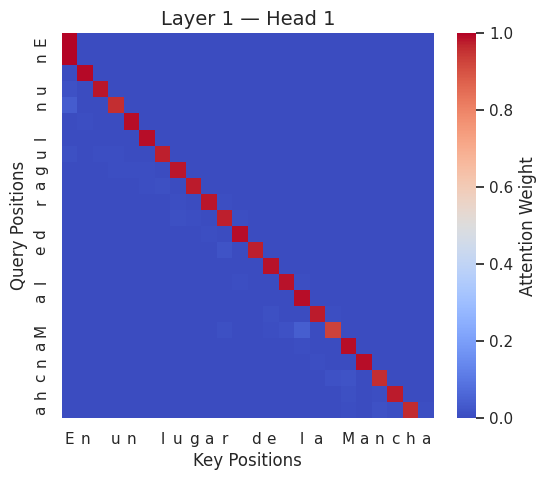

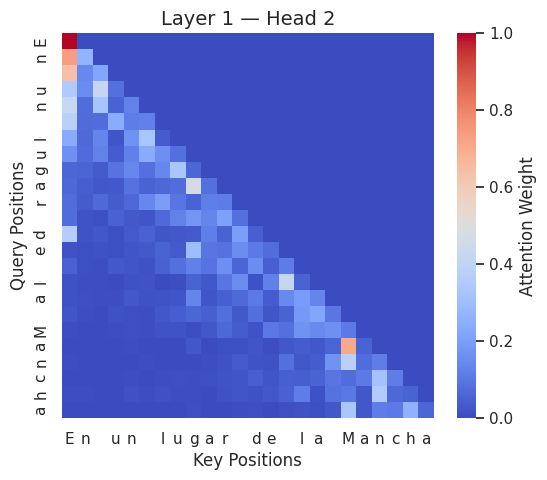

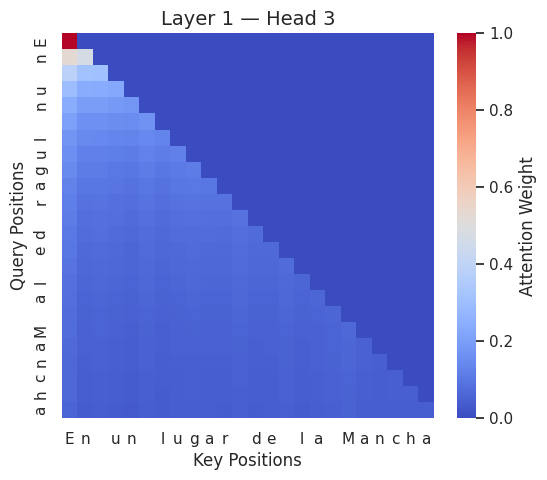

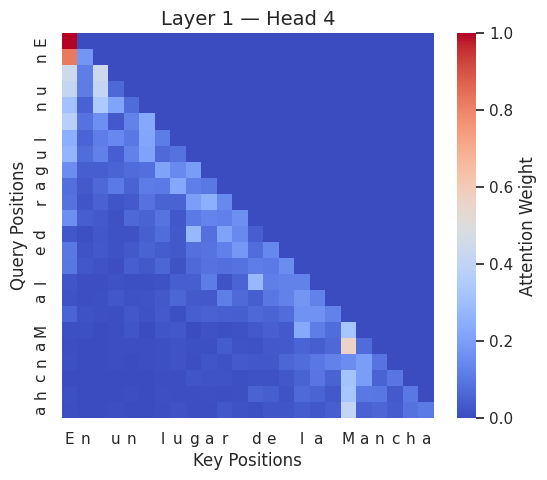

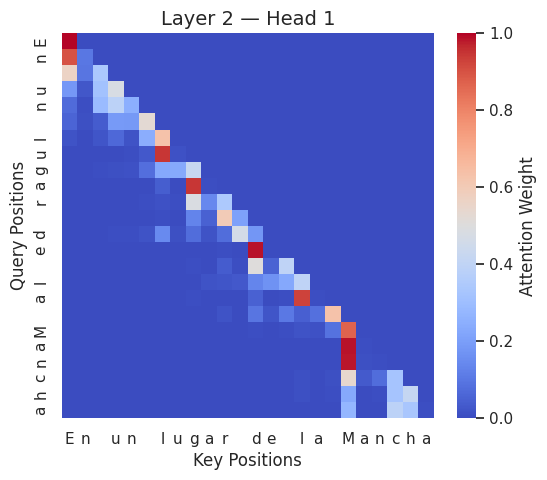

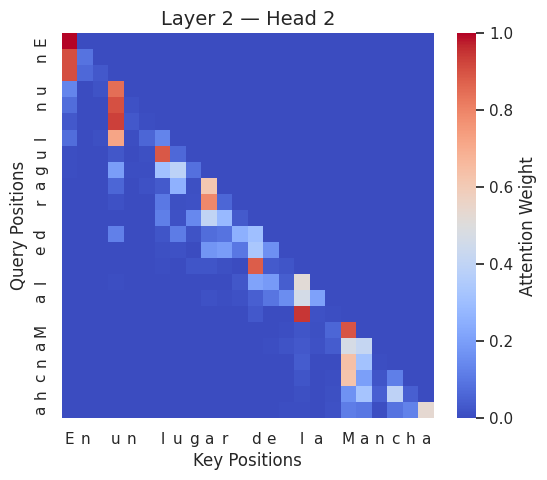

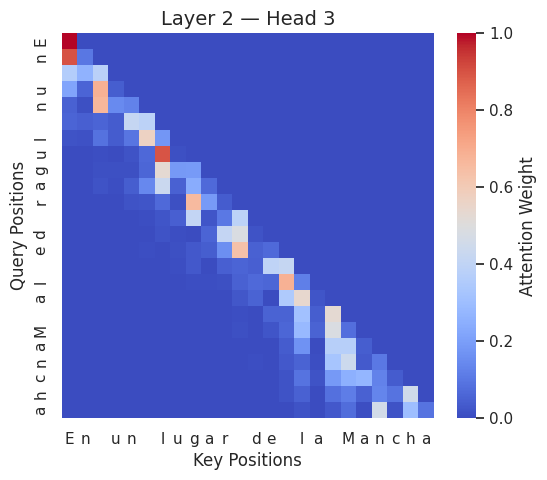

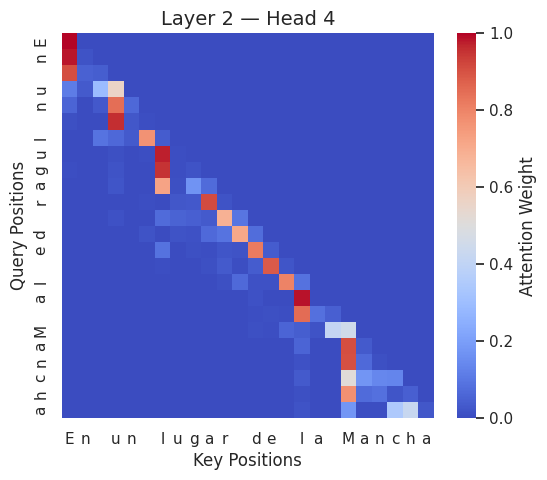

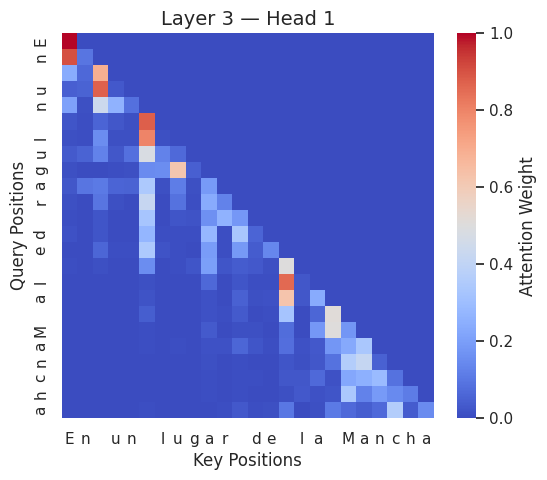

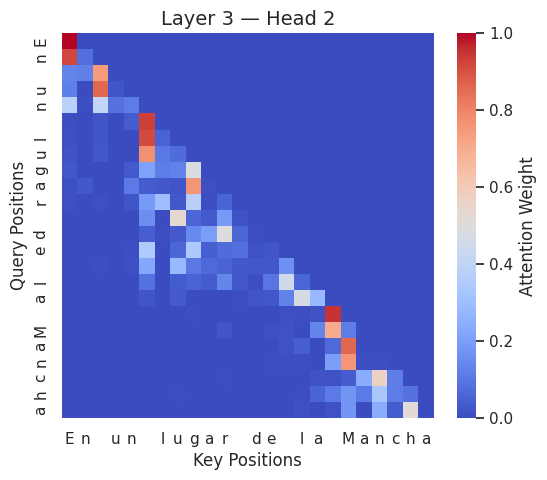

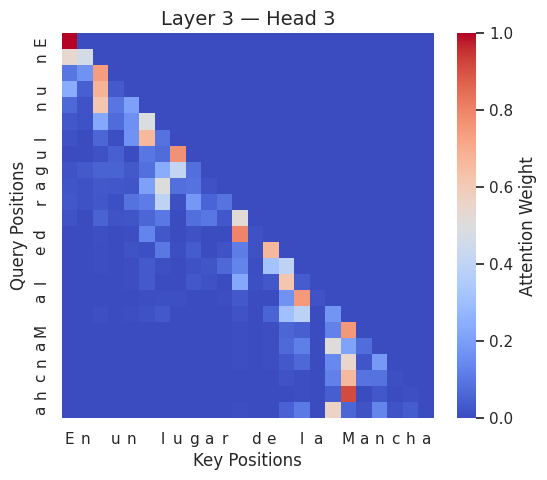

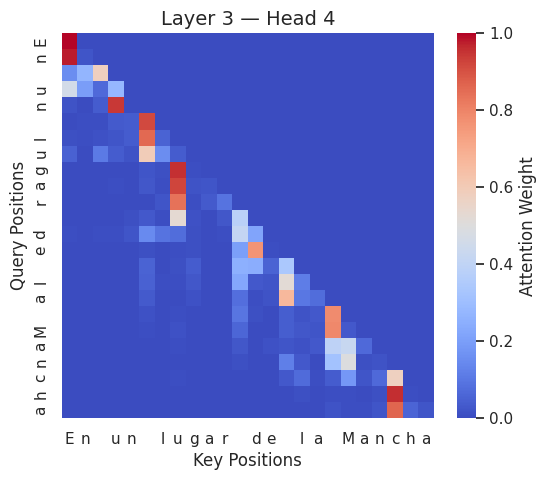

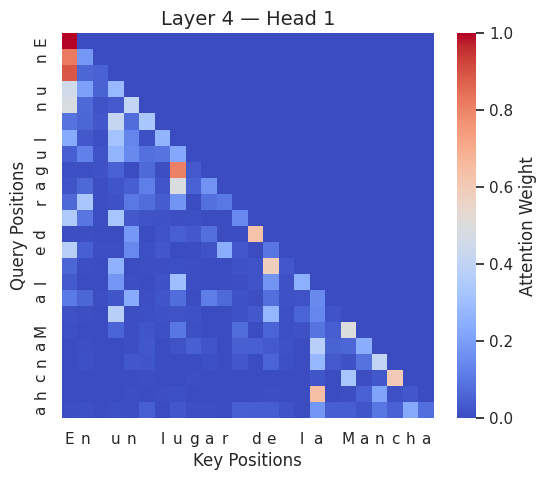

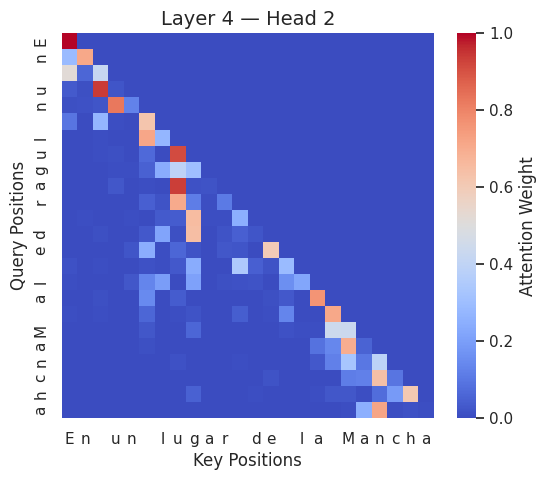

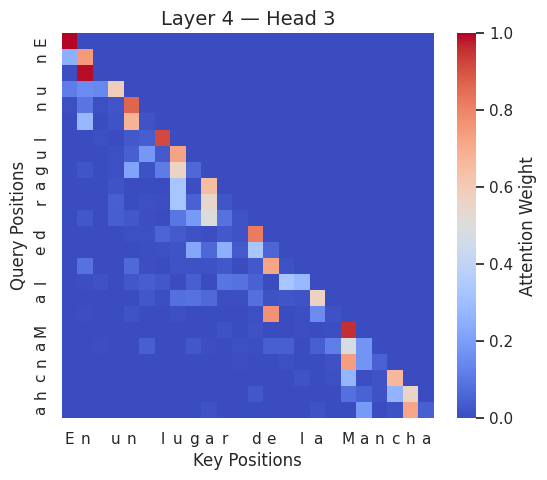

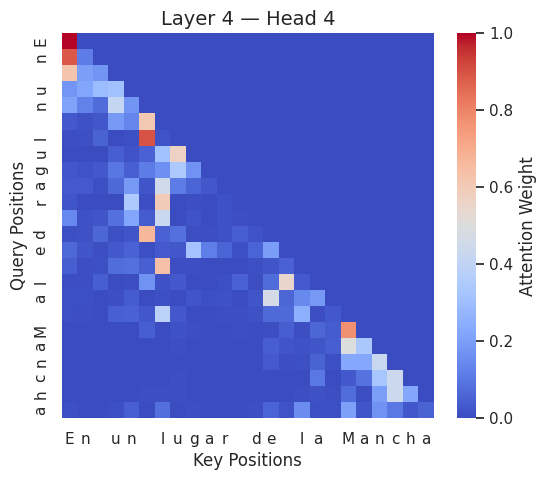

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

prompt = "En un lugar de la Mancha"
x = torch.tensor([encode(prompt)], dtype=torch.long, device=device)

model.eval()
with torch.no_grad():
    _, _, attentions = model(x)

for layer_idx, attn_matrix in enumerate(attentions):
    # attn_matrix shape: (B, n_heads, T, T)
    attn_matrix = attn_matrix[0]  # batch=1
    n_heads = attn_matrix.shape[0]
    
    for head_idx in range(n_heads):
        plt.figure(figsize=(6,5))
        matrix = attn_matrix[head_idx].cpu().numpy()
        sns.heatmap(
            matrix, cmap="coolwarm", vmin=0.0, vmax=1.0,
            xticklabels=list(prompt),
            yticklabels=list(prompt),
            cbar_kws={'label': 'Attention Weight'}
        )
        plt.title(f"Layer {layer_idx + 1} — Head {head_idx + 1}", fontsize=14)
        plt.xlabel("Key Positions")
        plt.ylabel("Query Positions")
        plt.show()

## **References & Further Reading**

- **Attention is All You Need** (Vaswani et al., 2017)  
- **GPT-3 Paper**: [Language Models are Few-Shot Learners](https://arxiv.org/abs/2005.14165)  
- **OpenAI’s GPT-2**: [https://openai.com/research/gpt-2](https://openai.com/research/gpt-2)  
- **The Illustrated Transformer**: [http://jalammar.github.io/illustrated-transformer/](http://jalammar.github.io/illustrated-transformer/)  